In [13]:
# import sys
# sys.path.append("../../")
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [30]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.RAW

num_decomps=2
num_subsets=3
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 2

### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(1.0, 1.0)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/datasets/mnist")

Extracting /home/jos/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow((img * 255.).astype(np.int32), interpolation='none', cmap="gray")
    plt.show()

### Process data

In [6]:
def process_set(data):
#     threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5).ravel()))
    images=np.vstack(resized)
    return images / 255.

1.0
255


/home/jos/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


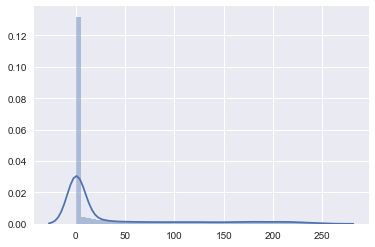

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/jos/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


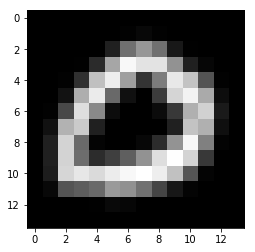

In [8]:
show_mnist(train_images[19])

In [9]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 196)


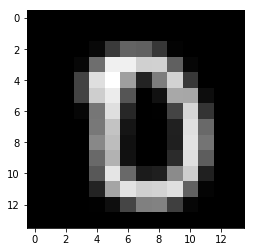

(6179, 196)


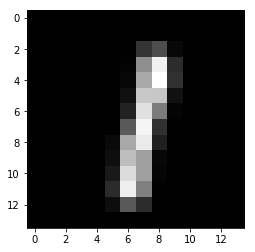

(980, 196)


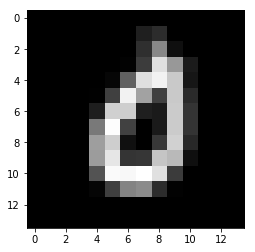

(1135, 196)


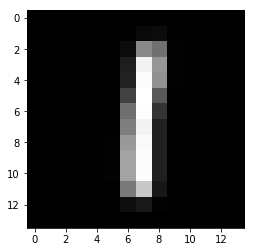

In [10]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

In [11]:
mean_init = np.tile(np.reshape(np.linspace(0, 1, 4), (1, 4)), (196, 1))

# Generate SPN structure
It is difficult to understand the likelihood drop when jointly training weights, means and variances if one initializes the means and variances using the method described in the paper by Poon and Domingos (2012). Things that have been considered
- `MIXTURE` vs. `RAW`
- Initializing weights to 1 instead of random
- Initial accumulator value
- Turning off learning only for variances

In [38]:
tf.reset_default_graph()
train_set = np.concatenate([train_images_0, train_images_1], 0)
gauss_quantiles = spn.GaussianLeaf(num_vars=196, num_components=4, mean_init=mean_init, variance_init=1e-2, total_counts_init=5 * len(train_set),
                                   learn_dist_params=True, train_var=True, train_mean=True, learn_scale=True, 
                                   use_prior=True, min_stddev=1e-8)
# gauss_quantiles.learn_from_data(train_images)
dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                            input_dist=input_dist, num_input_mixtures=num_input_mixtures,
                                            node_type=spn.DenseSPNGeneratorLayerNodes.NodeType.LAYER)
root0 = dense_gen.generate(gauss_quantiles)
root1 = dense_gen.generate(gauss_quantiles)
root = spn.Sum(root0, root1)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

34


1.0


/home/jos/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


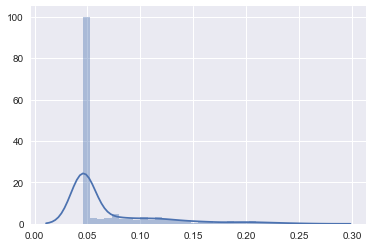

In [87]:
%matplotlib inline
import seaborn as sns
print(train_set.max())
sns.distplot(np.sqrt(gauss_quantiles._variance_init.ravel()))

# Add Learning Ops

In [39]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          use_unweighted=True, initial_accum_value=5 * len(train_set))
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

# Run Training

In [19]:
sess=None #https://github.com/whsu/spn/tree/master/spn

In [40]:
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

writer = tf.summary.FileWriter("tflogs_mnist_continuous")

summarize_mean = tf.summary.histogram("GaussianLeafMeans", gauss_quantiles.mean_variable)
summarize_variance = tf.summary.histogram("GaussianLeafVariances", gauss_quantiles.variance_variable)

# weights = tf.get_collection('spn_weights')
# summarize_weights = tf.summary.histogram("Weights", tf.concat(weights, axis=0))
# weight_maxes = [tf.reduce_max(w) for w in weights]
# weight_dominances = [(tf.reduce_sum(w) - m) / (m + 1e-10) for w, m in zip(weights, weight_maxes)]
# weight_dom = tf.summary.histogram("WeightDominance", tf.stack(weight_dominances))
# sparseness = tf.summary.scalar("SparsenessMixtureCounts", tf.reduce_mean(
#     tf.cast(tf.equal(learning._mpe_path.counts[gauss_quantiles], 0), tf.float32)))
merged = tf.summary.merge([summarize_mean, summarize_variance])

In [44]:
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()

sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=64
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0

accumulators = [node.accum for node in learning._gaussian_leaf_nodes]
sum_data = [node.sum_data for node in learning._gaussian_leaf_nodes]
sum_data_squared = [node.sum_data_squared for node in learning._gaussian_leaf_nodes]

mean_history = []
variance_history = []

while abs(prev_likelihood - likelihood)>0.1:
    prev_likelihood=likelihood
    likelihoods = []
    pbar = tqdm_notebook(range(num_batches))
    train_set, train_labels = shuffle(train_set, train_labels)
    writer.add_summary(sess.run(merged), epoch)
    mn, vr = sess.run([gauss_quantiles.mean_variable, gauss_quantiles.variance_variable])
    mean_history.append(mn)
    variance_history.append(vr)
    for batch in pbar:
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
#         print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
#         print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _ = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={gauss_quantiles: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
#         print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        pbar.set_description("Lh {}".format(avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
    sess.run(update_spn)
    
    
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
#     sess.run(reset_accumulators)



Avg likelihood: -18.50032651424408



Avg likelihood: 83.55953013896942



Avg likelihood: 111.96759450435638



Avg likelihood: 130.3923637866974



Avg likelihood: 144.65077304840088



Avg likelihood: 156.68872952461243



Avg likelihood: 167.32001328468323



Avg likelihood: 176.93109560012817



Avg likelihood: 186.01668977737427



Avg likelihood: 194.4689064025879



Avg likelihood: 202.45571112632751



Avg likelihood: 209.8794662952423



Avg likelihood: 217.17587208747864



Avg likelihood: 223.89957690238953


KeyboardInterrupt: 

In [27]:
import seaborn as sns
vals_per_q = gauss_quantiles._values_per_quantile(train_images)
# sns.distplot(gauss_quantiles._variance_init.ravel())
# print(variance_history[-1])
print(vals_)

In [2]:
print("hi")

hi


In [30]:
vals_per_q[0].min()

0.0

NameError: name 'mean_history' is not defined

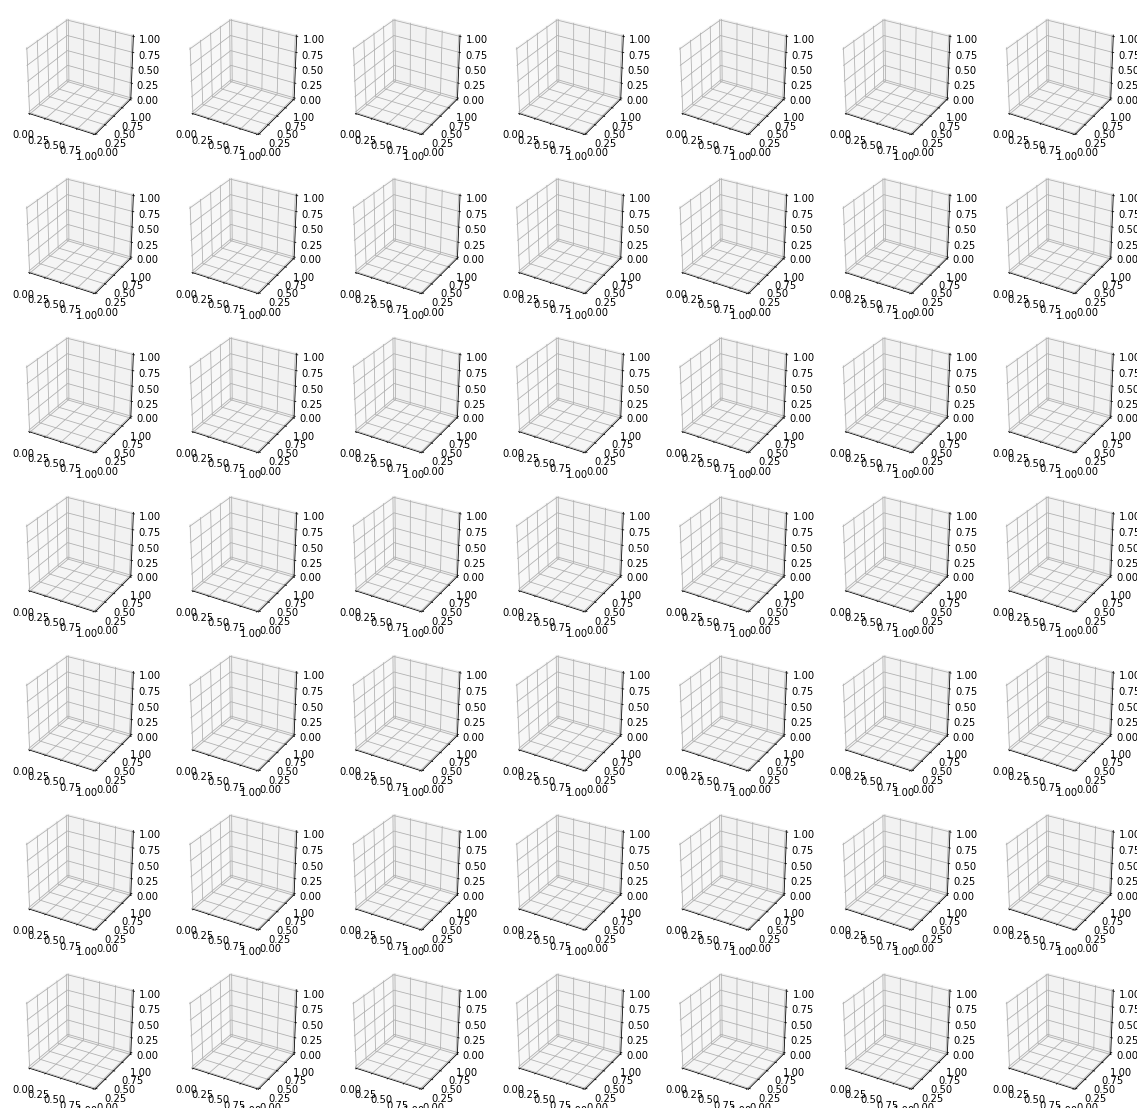

In [1]:
%matplotlib inline
# %autoreload
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d.axes3d import Axes3D
nrows, ncols = 8, 8
fig, axes = plt.subplots(nrows=7, ncols=7, subplot_kw={"projection": "3d"})
fig.set_size_inches((20, 20))

colors = ['r', 'g', 'b', 'm']

for row in range(0, 14, 2):
    for col in range(0, 14, 2):
        var_index = row * 14 + col  #, mixture_index = np.random.randint(14 * 14), np.random.randint(2)
        length = len(mean_history)
        minx, maxx, miny, maxy, minz, maxz = np.inf, -np.inf, np.inf, -np.inf, np.inf, -np.inf
        
        r, c = row // 2, col // 2
        
        for t in range(length):
            for mixture_index in range(4):
                mu, sigma = mean_history[t][var_index, mixture_index], variance_history[t][var_index, mixture_index]
                std = np.sqrt(sigma)
                x = np.linspace(-0.1, 1.1, 100)
                z = stats.norm(loc=mu, scale=std).pdf(x)
                z /= z.max()
                y = 1 - np.ones(x.shape) * t / length
                minx = min(minx, x.min())
                miny = min(miny, y.min())
                maxx = max(maxx, x.max())
                maxy = max(maxy, y.max())
                minz = min(maxz, z.min())
                maxz = max(maxz, z.max())
                
                axes[r][c].plot(x, y, z, '{}-'.format(colors[mixture_index]), alpha=(t + length) / (length * 2))
        axes[r][c].set_xticks([], [])
        axes[r][c].set_yticks([], [])
        axes[r][c].set_zticks([], [])
        
        axes[r][c].set_xlim([-.1, 1.1])
        axes[r][c].set_ylim([miny, maxy])
        axes[r][c].set_zlim([minz, maxz])
        axes[r][c].view_init(30, -80)
plt.savefig("gauss_4components_equidistant_means_var1e-2_5lendat_offline.png")
# print(flat_sum_data_sq)
# print(np.unique(flat_accum).size)

# Generate Testing Ops

In [25]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [26]:
mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)

In [ ]:
# mpe_gauss_quant = tf.where(tf.equal(mpe_latent, 0), mpe_gauss_quantiles0, mpe_gauss_quantiles1)

# Run Testing

### MPE of the whole network

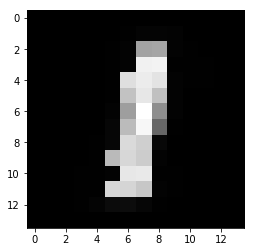

[[1]]


In [27]:
no_evidence = np.zeros((1, 14 * 14)).astype(np.bool) 
mpe_gauss_val, mpe_latent_val = sess.run([mpe_gauss_quantiles, mpe_latent], feed_dict={
    gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[-1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 0

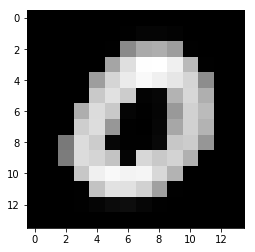

[[0]]


In [28]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[0]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 1

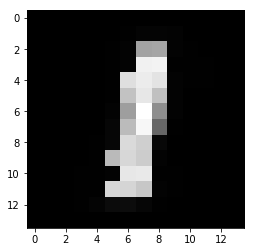

[[1]]


In [29]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### Classification of Training Data

In [99]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={
    gauss_quantiles: train_set, latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

ResourceExhaustedError: OOM when allocating tensor with shape[11623,3712,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: LogValue_1/Layer6_1/ProductsLayer-6.1/gather_cols_3d/GatherColumns3d = GatherColumns3d[IndT=DT_INT64, T=DT_FLOAT, pad_elem=0, padding=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](LogValue_1/Layer6_1/ProductsLayer-6.1/concat, LogValue_1/Layer6_1/ProductsLayer-6.1/gather_cols_3d/GatherColumns3d/indices)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: MPEState/ArgMax_1/_1331 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_220_MPEState/ArgMax_1", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'LogValue_1/Layer6_1/ProductsLayer-6.1/gather_cols_3d/GatherColumns3d', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jos/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jos/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/jos/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/jos/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jos/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jos/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jos/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jos/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jos/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jos/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jos/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jos/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jos/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-95-1a6f4b726919>", line 1, in <module>
    mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)
  File "/home/jos/spn/libspn/libspn/inference/mpe_state.py", line 54, in get_state
    self._mpe_path.get_mpe_path(root, sequence_lens=sequence_lens)
  File "/home/jos/spn/libspn/libspn/inference/mpe_path.py", line 131, in get_mpe_path
    self._get_mpe_path_fixed_graph(root)
  File "/home/jos/spn/libspn/libspn/inference/mpe_path.py", line 115, in _get_mpe_path_fixed_graph
    self._value.get_value(root)
  File "/home/jos/spn/libspn/libspn/inference/value.py", line 102, in get_value
    all_values=self._values)
  File "/home/jos/spn/libspn/libspn/graph/algorithms.py", line 147, in compute_graph_up
    last_val = val_fun(next_node, *input_vals)
  File "/home/jos/spn/libspn/libspn/inference/value.py", line 97, in fun
    return node._compute_log_mpe_value(*args)
  File "/home/jos/spn/libspn/libspn/graph/productslayer.py", line 264, in _compute_log_mpe_value
    return self._compute_log_value(*value_tensors)
  File "/home/jos/spn/libspn/libspn/graph/productslayer.py", line 256, in _compute_log_value
    values = self._compute_value_common(*value_tensors, padding_value=0.0)
  File "/home/jos/spn/libspn/libspn/graph/productslayer.py", line 243, in _compute_value_common
    pad_elem=padding_value)
  File "/home/jos/spn/libspn/libspn/utils/math.py", line 210, in gather_cols_3d
    return ops.gather_cols_3d(params, indices, padding, pad_elem)
  File "<string>", line 53, in gather_columns3d
  File "/home/jos/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 328, in apply_op
    op_type_name, name, **keywords)
  File "/home/jos/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jos/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/jos/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[11623,3712,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: LogValue_1/Layer6_1/ProductsLayer-6.1/gather_cols_3d/GatherColumns3d = GatherColumns3d[IndT=DT_INT64, T=DT_FLOAT, pad_elem=0, padding=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](LogValue_1/Layer6_1/ProductsLayer-6.1/concat, LogValue_1/Layer6_1/ProductsLayer-6.1/gather_cols_3d/GatherColumns3d/indices)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: MPEState/ArgMax_1/_1331 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_220_MPEState/ArgMax_1", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



### Classification of Test Data

In [100]:
test_set = np.concatenate([test_images_0, test_images_1], 0)
test_labels = np.concatenate([np.ones((test_images_0.shape[0]))*0, 
                               np.ones((test_images_1.shape[0]))*1])
test_labels=np.reshape(test_labels, (-1, 1))

In [101]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={gauss_quantiles: test_set, 
                                                   latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.9957446808510638